# Train as you fight - with seedlings

Or why should we care abaout data collection? 

As kagglers we have to take data as it was provided for us and it's not seldom that a dataset has some kind of unconscious leakage that was introduced the way it was collected. This can mislead a model during learning and in the end the "knowledge" of the model is not what you expect it to be. With this kernel I invite you to dive deeper into this kind of problem. Let's explore a research image dataset with 12 different common species in Danish agriculture of cultivated and wild plants. 

<img src="https://images.unsplash.com/photo-1457530301326-d55420c9898a?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1950&q=80" width="600px">


We like to develop a model that is able to classify the correct species given an image with seedlings. Solving this task we would be able to address an important problem of agriculture industries: Plants in the early-growth phase are heavily competing for nutrients and water and often this phase is crucial for a plant to prevail against all other seedlings. Consequently if we would be able to detect wild plants in early phases we could remove them manually which is an advantage for all crop seedlings.  

So let's start and see why this dataset is not sufficient to solve this kind of problem! ;-)

## Table of contents

* [Prepare to start](#load)
* [Peek at the image files](#peek)
    * [How many images per species do we have?](#speciescount)
    * [How do the species classes look like?](#examples)
* [An unconscious target leakage](#leakage)
    * [Can we find some order in the names of the image files?](#filenames)
    * [Does the images size reveal the growth state and the species?](#reveal)
    * [Uncovering the target leakage](#targetleakage)
* [What happens during training if we ignore the leakage?](#ignore)
    * [Transfer learning with pytorch](#transfer)
    * [Image preprocessing](#imagepreprocessing)
    * [Dataset and dataloader](#dataset)
    * [Validation strategy](#validation)
    * [Model definition](#definition)
    * [Training loop](#trainloop)
    * [Run training or load model](#runorload)
* [Explaining predictions with LIME](#lime)
    * [What is LIME doing?](#howlimeworks)
    * [Which components are important features in our images?](#imagecomponents)
* [Summary](#summary)

In [1]:
run_training=True

## Prepare to start <a class="anchor" id="load"></a>

We need to load some libraries:

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from imageio import imread

import seaborn as sns
sns.set_style("dark")
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.dataset import Subset
from torch.utils.data import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from IPython.display import HTML

import time
import copy
from tqdm import tqdm_notebook as tqdm
import cv2

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser

from lime import lime_image
from skimage.segmentation import mark_boundaries

Let's see what kind of data this kernel needs:

In [3]:
listdir("../input")

['seedlings',
 'pretrained-pytorch-models',
 'seedlingsmodel',
 'v2-plant-seedlings-dataset']

Given the pretrained pytorch models we will use one of them for transfer learning to predict the species classes. 

In [4]:
listdir("../input/seedlingsmodel")

['running_losses_segmented_seedlings.csv',
 'segmented_seedlings_cuda.pth',
 'losses_segmented_seedlings.csv']

This is the model we obtain after running the training loop in this kernel. I have stored it in a separate dataset to run this kernel faster everytime I'm editing this notebook. By this way I can just load the trained model and make predictions with it. 

## Peek at the image files <a class="anchor" id="peek"></a>

In [5]:
base_path = "../input/v2-plant-seedlings-dataset/nonsegmentedv2/"
OUTPUT_PATH = "seedlings.pth"
MODEL_PATH = "../input/seedlingsmodel/seedlings.pth"

* The output path describes where to save a trained model after running the training loop in this kernel. 
* The model path instead describes where to load an already trained model of this kernel. 
* The basepath directs to the images data of the seedlings.

### How many images per species do we have? <a class="anchor" id="speciescount"></a>

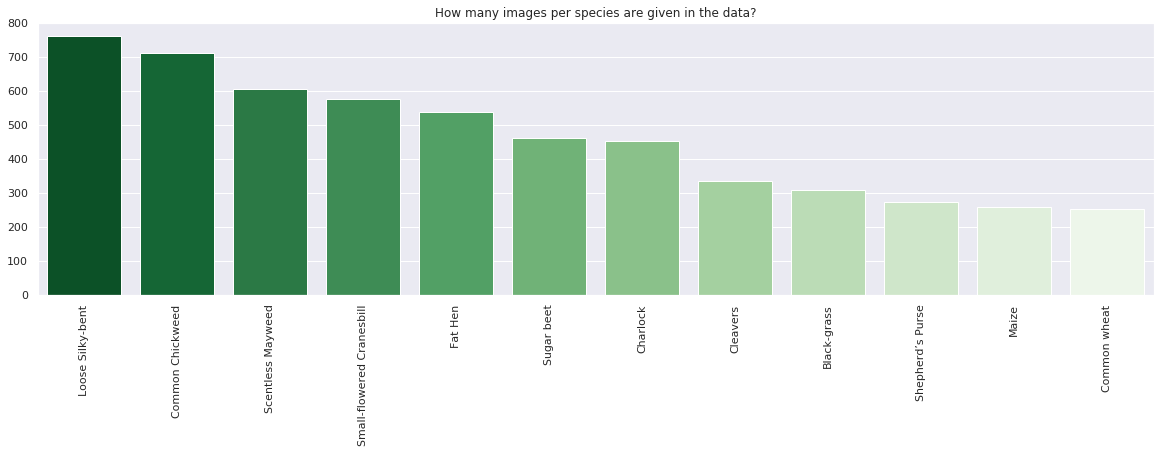

In [6]:
subfolders = listdir(base_path)
names = []
counts = []

for folder in subfolders:
    images = listdir(base_path +folder)
    names.append(folder)
    counts.append(len(images))

counts = np.array(counts)
names = np.array(names)

idx = np.argsort(counts)[::-1]
    
plt.figure(figsize=(20,5))    
sns.barplot(x=names[idx], y=counts[idx], palette="Greens_r")
plt.xticks(rotation=90);
plt.title("How many images per species are given in the data?");

### Insights

* We have a lot of images that correspond to wild plants like: loose silky-bent, common chickweed, scentless mayweed, small-flowered cransbill, fat hen, charlock, cleavers, black-grass and shepherd's purse.
* In contrast seedlings that belong to common agriculture plants like sugar beet, maize and common wheat are less present.
* We have to deal with species **class-imbalance**.

Now, let's take a look at some examples:

### How do the species classes look like? <a class="anchor" id="examples"></a>

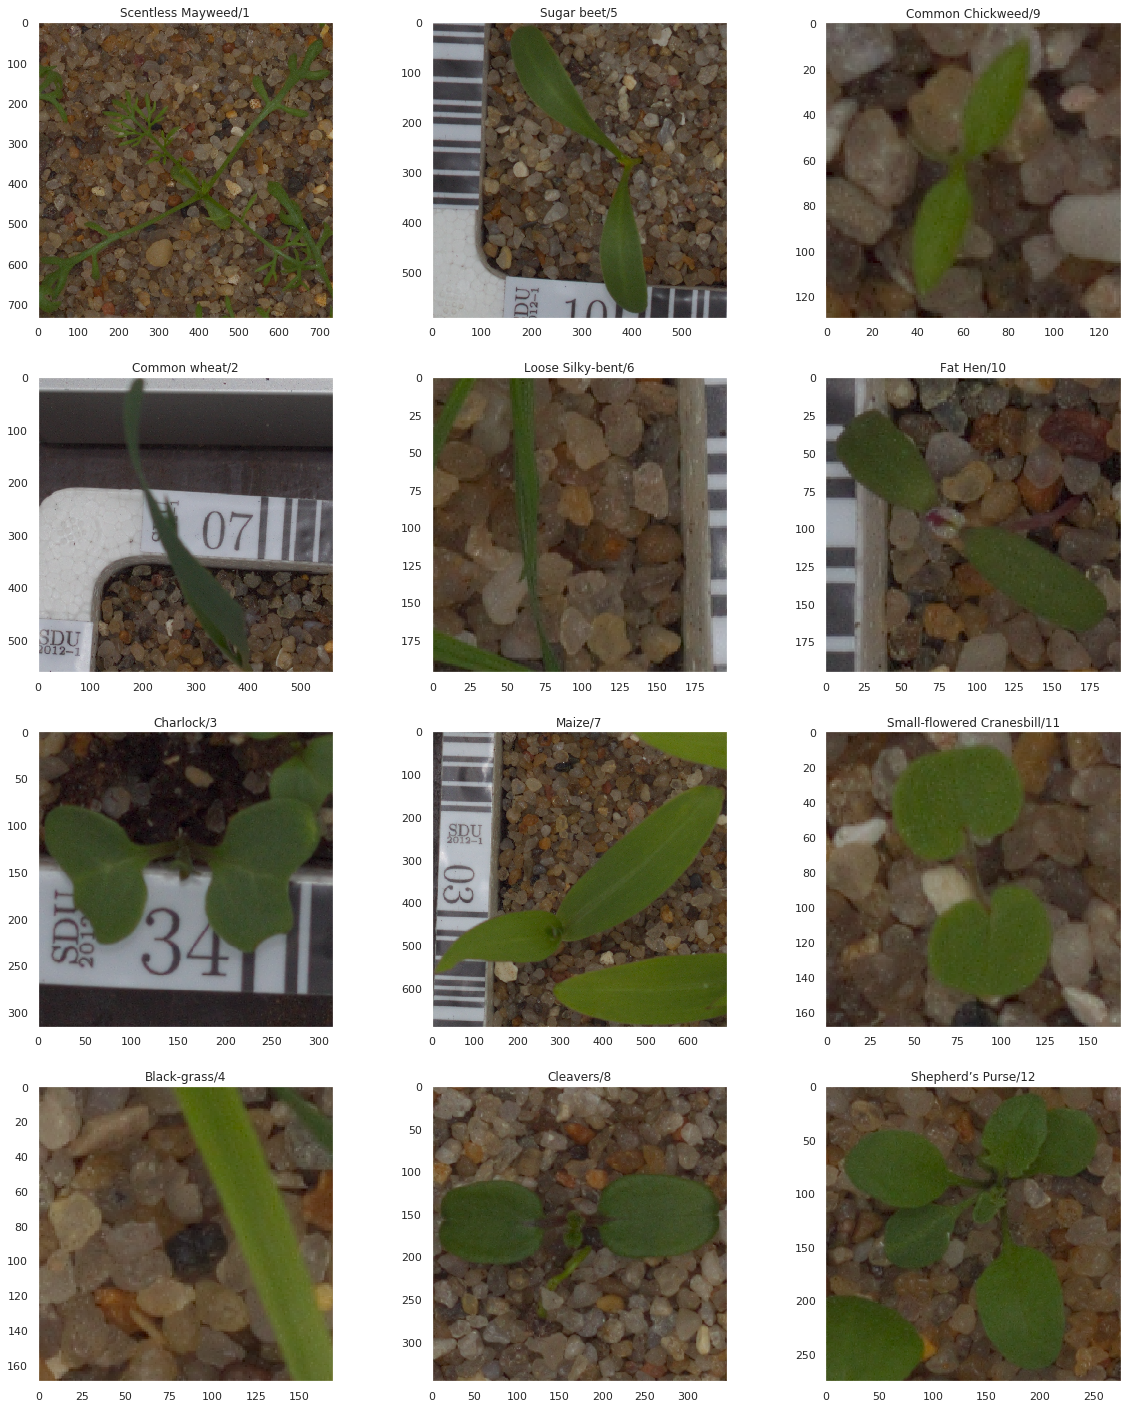

In [7]:
fig, ax = plt.subplots(4,3,figsize=(20,25))

for m in range(4):
    for n in range(3):
        folder = subfolders[m+n*4]
        files = listdir(base_path + folder + "/")
        image = imread(base_path + folder + "/" + files[0])
        ax[m,n].imshow(image)
        ax[m,n].grid(False)
        ax[m,n].set_title(folder + "/" + str(m+n*4+1))

### Insights

* The images of the seedlings were taken on **different scales**. The image areas differ in pixel ranges (heigth and width). Why is this the case? Some images look similar in the ranges. Perhaps images of the same growth stage were taken with the same size? Or was there a manual cropping of images afterwards?
* **By looking at the stones we can see that images with larger heigth and width are zoomed out (small stones) whereas small images are zoomed in (larger stones)**.
* Furthermore we can see **additional material** in some of the images: A measureing tape and a container wall.
* Last but not least - **Some images seem to be defocussed and blurred**. 
* We still have to check for more findings by iterating through the images. For this purpose I like to setup an image iterator later. But for a peek this is already sufficient.

## An unconscious target leakage <a class="anchor" id="leakage"></a>

### Can we find some order in the names of the image files? <a class="anchor" id="filenames"></a>

The image names are counters:

In [8]:
listdir(base_path + "Maize")[0:10]

['173.png',
 '248.png',
 '94.png',
 '236.png',
 '48.png',
 '227.png',
 '238.png',
 '61.png',
 '222.png',
 '37.png']

Perhaps the way images were enumerated is not random and some kind of order is hidden in the file names. It would be of great advantage if the numeration has something to do with the growth state as well:

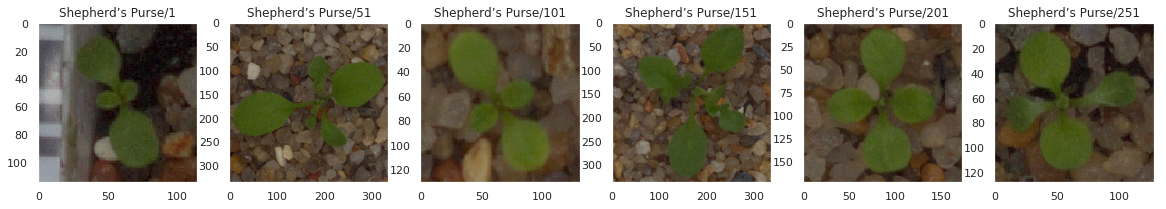

In [9]:
image_indices = np.array([0, 50, 100, 150, 200, 250])+1

fig, ax = plt.subplots(1,6,figsize=(20,5))

for n in range(6):
    idx = image_indices[n]
    image = imread(base_path + folder + "/" + str(idx) + ".png")
    ax[n].imshow(image)
    ax[n].grid(False)
    ax[n].set_title(folder + "/" + str(idx))


No, the latter is not the case. **Images of one species are not zooming out with higher number in the image name**. 

### Does the images size reveal the growth state and the species? <a class="anchor" id="reveal"></a>

To answer this question let's load all images one after another and store the species together with image heigth and width into a pandas dataframe:

In [10]:
total_images = 0
for folder in subfolders:
    total_images += len(listdir(base_path + folder))

plantstate = pd.DataFrame(index=np.arange(0, total_images), columns=["width", "height", "species"])

k = 0
all_images = []
for m in range(len(subfolders)):
    folder = subfolders[m]
    
    images = listdir(base_path + folder)
    all_images.extend(images)
    n_images = len(images)
    
    for n in range(0, n_images):
        image = imread(base_path + folder + "/" + images[n])
        plantstate.loc[k, "width"] = image.shape[0]
        plantstate.loc[k, "height"] = image.shape[1]
        plantstate.loc[k, "species"] = folder
        plantstate.loc[k, "image_name"] = images[n]
        k+=1

plantstate.width = plantstate.width.astype(np.int)
plantstate.height = plantstate.height.astype(np.int)

In [11]:
plantstate.head()

width  height            species image_name
0    735     735  Scentless Mayweed    173.png
1    148     148  Scentless Mayweed    491.png
2     99      99  Scentless Mayweed    379.png
3    106     106  Scentless Mayweed    248.png
4    135     135  Scentless Mayweed     94.png

In [12]:
plantstate.shape

(5539, 4)

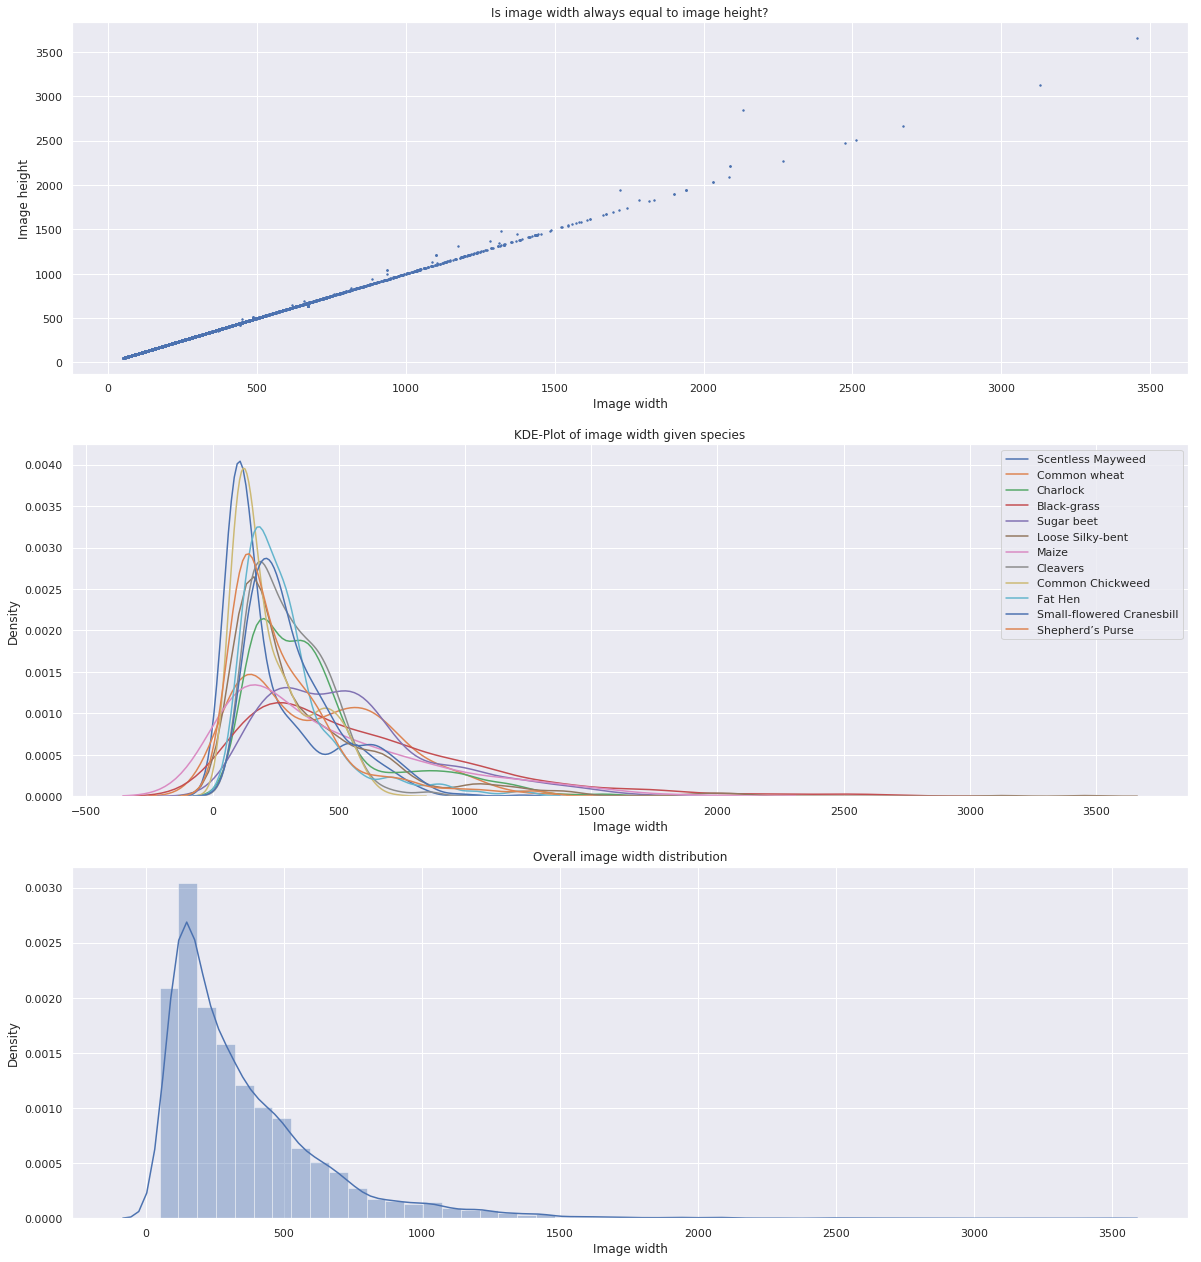

In [13]:
fig, ax = plt.subplots(3,1,figsize=(20,22))
ax[0].scatter(plantstate.width.values, plantstate.height.values, s=2)
ax[0].set_xlabel("Image width")
ax[0].set_ylabel("Image height");
ax[0].set_title("Is image width always equal to image height?")
for single in plantstate.species.unique():
    sns.kdeplot(plantstate[plantstate.species==single].width, ax=ax[1], label=single);
ax[1].legend();
ax[1].set_title("KDE-Plot of image width given species")
ax[1].set_xlabel("Image width");
ax[1].set_ylabel("Density")
sns.distplot(plantstate.width, ax=ax[2]);
ax[2].set_xlabel("Image width")
ax[2].set_ylabel("Density")
ax[2].set_title("Overall image width distribution");

#### Insights

* Most of the images are **quadratic**. There are some outliers we should take a look at to understand why they are different. Perhaps we want to exclude them from our analysis. 
* Looking at the kde-plots of the species, we can observe:
    * Almost all species have extreme outliers!
    * There are at least two major groups of image sizes. 
    * All distributions are right skewed: Smaller images are more common! 

### Uncovering the target leakage <a class="anchor" id="targetleakage"></a>

On the kde-plots of image widths per species we have observed that there are at least two image shape groups that may correlate with the growth state of a plant. Let's take a closer look at the logarithmic growth state:

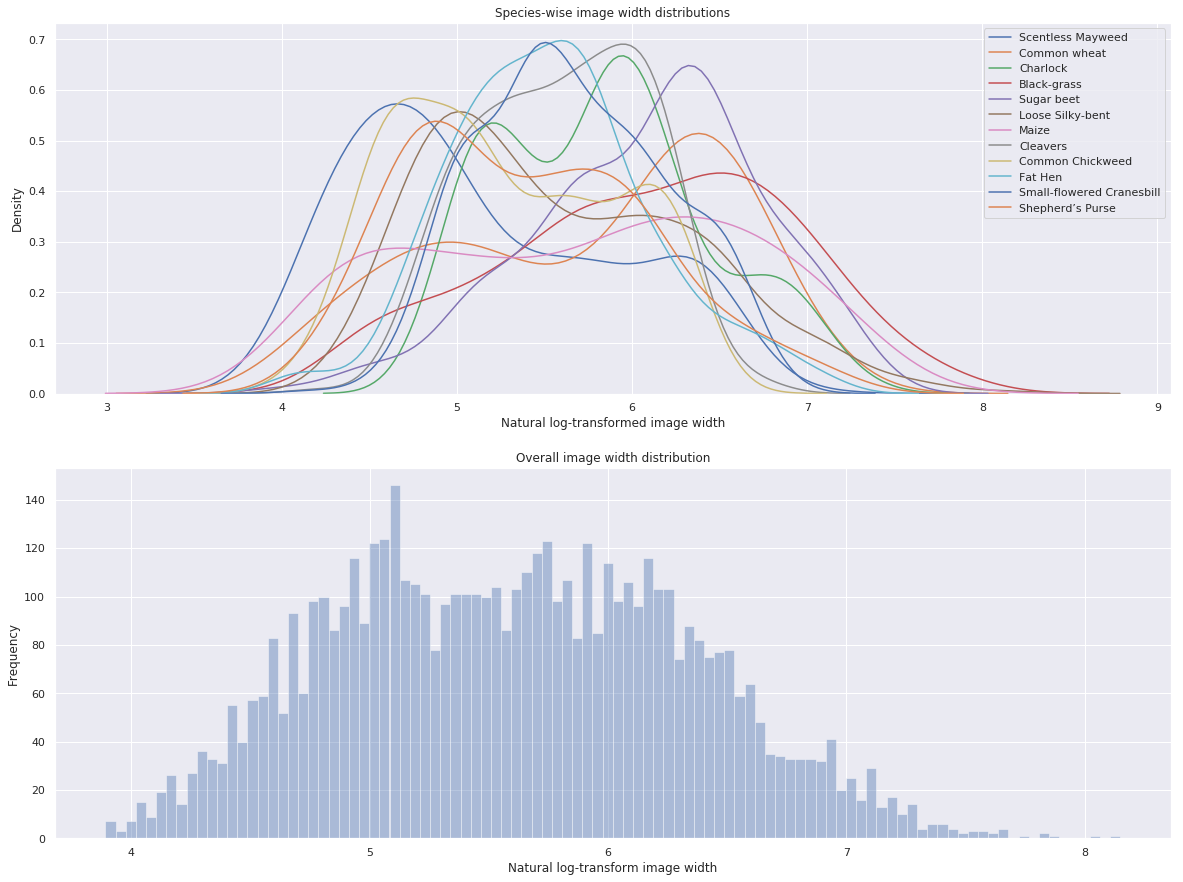

In [14]:
fig, ax = plt.subplots(2,1,figsize=(20,15))
for single in plantstate.species.unique():
    sns.kdeplot(np.log(plantstate[plantstate.species==single].width.values), label=single, ax=ax[0]);
ax[0].set_title("Species-wise image width distributions")
ax[0].set_xlabel("Natural log-transformed image width")
ax[0].set_ylabel("Density");
sns.distplot(np.log(plantstate.width.values), ax=ax[1], bins=100, kde=False);
ax[1].set_xlabel("Natural log-transform image width")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Overall image width distribution");

#### Insights

* Given the natural log of the image widths we can see much more than 2 groups (3-5).
* To which group an image belongs highly depends on the species of the plant! 
* Consequently the probability of observing a specific species is given by the image shape!!! 
* You might say that this leakge is not given if we resize the images, but it's still there as the growth state is also reflected by the size of the stones in the images! 

This gives rise to the following assumption about the data collection: **Photos were taken at specific time points to cover different growth states of all plants**. To be fully covered by the image **some plant species need larger images than others** given a specific time point. 


#### Why is this a leakage?

If this is true then **we have observed a so called data leakage**: It was not intended that we can infer the growth state and predict the species given the shape of the images! In a competition we can use this kind of information to improve our model performance and to yield best evaluation scores. **In real situations and use cases we have to be careful with such kind of leakages**. We would still want our model to be able to predict the species if someone else starts to take photos that may not follow the patterns we have found in this data.    

#### Clustering the growth states <a class="anchor" id="statecluster"></a>

To visualize the different species probabilities per growth state let's cluster the growth states with a simple k-means approach and create a heatmap of species frequencies given the state:

In [15]:
scaler = StandardScaler()

X = np.log(plantstate.width.values).reshape(-1,1)
X = scaler.fit_transform(X)

km = KMeans(n_clusters=5)
plantstate["growth_state"] = km.fit_predict(X)

In [16]:
mean_states = plantstate.groupby("growth_state").width.mean().values
state_order = np.argsort(mean_states)
mean_states

array([ 167.08216292,  524.54846154,  297.47512617,   95.16389812,
       1041.48      ])

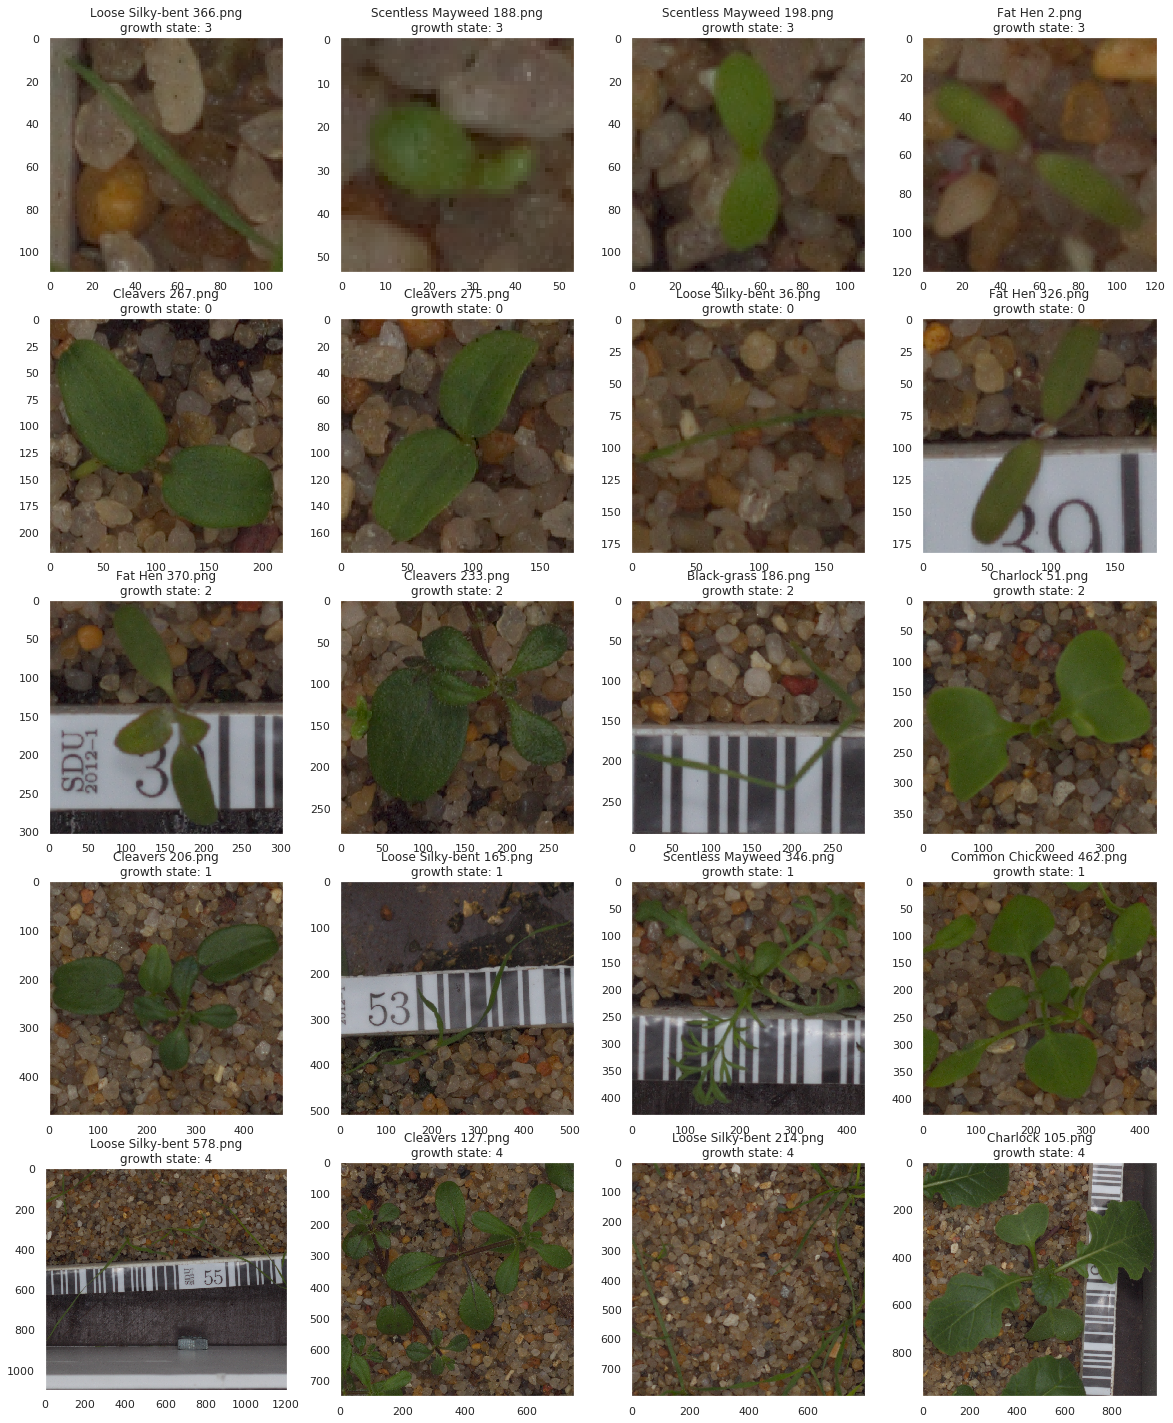

In [17]:
fig, ax = plt.subplots(len(state_order), 4, figsize=(20,5*len(state_order)))

for n in range(len(state_order)):
    your_state=state_order[n]

    example = np.random.choice(plantstate[plantstate.growth_state==your_state].index.values, size=4)
    species = plantstate.loc[example].species.values
    for m in range(4):
        image_id = all_images[example[m]]
        image = imread(base_path + species[m] + "/" + image_id)
        ax[n,m].imshow(image)
        ax[n,m].set_title(species[m] + " " + image_id + "\n" + "growth state: " + str(your_state))
        ax[n,m].grid(False);

Yeha! 

Now you can clearly see that **the image size is related to the growth state of the plants!** But does this also tell us how likely it is to observe a specific species?

#### Exploring the target leakage

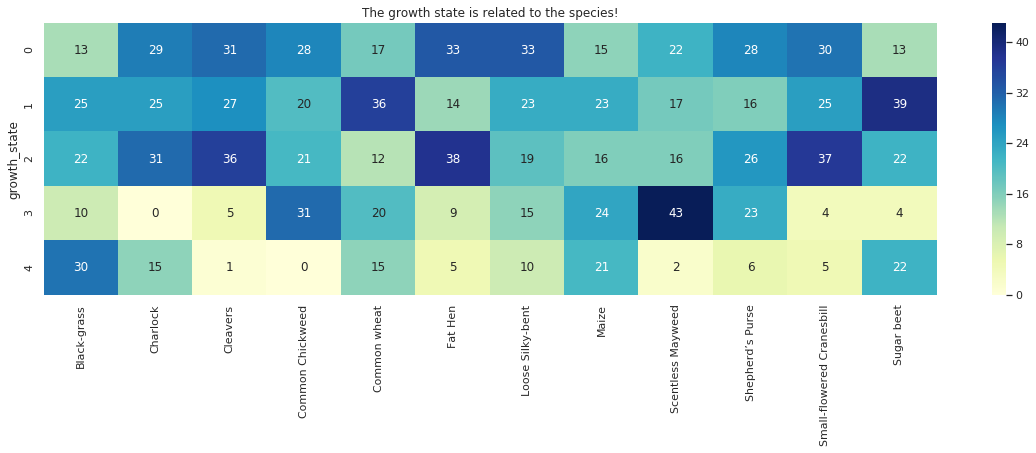

In [18]:
target_leakage = plantstate.groupby(["growth_state", "species"]).size().unstack().fillna(0) 
target_leakage = target_leakage / plantstate.species.value_counts() * 100
target_leakage = target_leakage.apply(np.round).astype(np.int)

plt.figure(figsize=(20,5))
sns.heatmap(target_leakage, cmap="YlGnBu", annot=True)
plt.title("The growth state is related to the species!");

### Insights

* Now you can see it directly. Take a look at scentless mayweed: 43 % plants of this class can be found in growth state 1. 
* This is a very bad leakage! Scentless mayweed is a common species in this dataset. Consequently our CNN could decide to predict this species when the stones of the images look very big (as this feature characterizes the related growth state). 
* Due to the fact that we have a class imbalance in the dataset this leakage becomes more dramatic. It should not be easy to detect it by only looking at the error analysis of a model. 

## What happens during training if we ignore the target leakage? <a class="anchor" id="ignore"></a>

Understanding and exploring the data is a very important part of the data science workflow. Nonetheless I see it quite often that people just apply models and take predictions as they are (after doing some hyperparameter tuning). In our seedlings case this would be bad idea due to the target leakage. Let's discover the illness of a model that is just applied to this data. ;-)

### Transfer learning with pytorch <a class="anchor" id="transfer"></a>

We are going to use transfer learning with pytorch to classify the plant species as our dataset is pretty small to train from scratch. We will fine-tune a network that was already trained on the imagenet dataset. By retraining the last fully connected layer of the network we adapt to the new task of classifying the seedling species. Usually this is sufficient as the fully connected layers hold most of the parameters. To setup the pipeline we need to label encode the species targets: 

In [19]:
encoder = LabelEncoder()
labels = encoder.fit_transform(plantstate.species.values)
plantstate["target"] = labels

NUM_CLASSES = plantstate.target.nunique()
org_plantstate = plantstate.copy()

And we need to write a dataset class that uses our transform method to perform image preprocessing:

### Image preprocessing <a class="anchor" id="imagepreprocessing"></a>

In [20]:
def transform(key="train"):
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(size=256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    return data_transforms[key]

You can see that we are using image augmentations like random flips to increase the variability of the data. The images are resized and cropped to the target size of our pretrained model. Often the desired shape is (224,224,3) but it depends on the model. The resizing still leads to images with target leakage. Stones is small images become even larger and stones in large images become smaller. We will still be able to deduce the species given the size of the stones in an image.

### Dataset and Dataloader <a class="anchor" id="dataset"></a>

We need to write a small dataset class to load images and targets given the path of an image:

In [21]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class SeedlingsDataset(Dataset):
    
    def __init__(self, root_dir, df, transform=None):
        self.root_dir = root_dir
        self.states = df
        self.transform=transform
      
    def __len__(self):
        return len(self.states)
        
    def __getitem__(self, idx):
        image_path = self.root_dir + self.states.species.values[idx] + "/" 
        image_path += self.states.image_name.values[idx]
        image = Image.open(image_path)
        image = image.convert('RGB')
        
        if self.transform:
            image = self.transform(image)
         
        target = self.states.target.values[idx]
        
        
        return {"image": image, "label": target}

### Validation strategy <a class="anchor" id="validation"></a>

Let's just split the data into train and dev set given a traditional fraction of 0.7 for training and 0.3 for evaluating the model performance. 

In [22]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(plantstate.index.values,
                                       test_size=0.3,
                                       random_state=2019,
                                       stratify=plantstate.target.values)

train_df = plantstate.loc[train_idx].copy()
val_df = plantstate.loc[test_idx].copy()

train_dataset = SeedlingsDataset(base_path, train_df, transform=transform(key="train"))
eval_dataset = SeedlingsDataset(base_path, val_df, transform=transform(key="val"))
image_datasets = {"train": train_dataset, "val": eval_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print(len(train_dataset), len(eval_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, drop_last=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=32, shuffle=False, drop_last=True)
dataloaders = {"train": train_dataloader, "val": eval_dataloader}

3877 1662


### Model definition <a class="anchor" id="definition"></a>

Let's use resnet18 to get started:

In [23]:
listdir("../input/pretrained-pytorch-models/")

['squeezenet1_0-a815701f.pth',
 'inception_v3_google-1a9a5a14.pth',
 'resnet18-5c106cde.pth',
 'squeezenet1_1-f364aa15.pth',
 'densenet161-17b70270.pth',
 'resnet50-19c8e357.pth']

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Only retrain the fully connected layer that direct to our output for 12 species classes:

In [25]:
model = torchvision.models.resnet18(pretrained=False)
if run_training:
    model.load_state_dict(torch.load("../input/pretrained-pytorch-models/resnet18-5c106cde.pth"))
num_features = model.fc.in_features
print(num_features)

model.fc = nn.Linear(num_features, NUM_CLASSES)
model = model.to(device)

512


To reduce the effect of class imbalance let's use a weighted cross entropy loss: 

In [26]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(y=train_df.target.values, class_weight="balanced", classes=train_df.target.unique())
class_weights = torch.FloatTensor(weights).cuda()

In [27]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.fc.parameters(), 1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

### Training Loop <a class="anchor" id="trainloop"></a>

In [28]:
def train_loop(model, criterion, optimizer, scheduler, num_epochs = 10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ["train", "val"]:
            if phase == "train":
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            tk0 = tqdm(dataloaders[phase], total=int(len(dataloaders[phase])))

            counter = 0
            for bi, d in enumerate(tk0):
                inputs = d["image"]
                labels = d["label"]
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.long)
                
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                
                if phase == "train":
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        
                        loss = criterion(outputs, labels)
                        loss.backward()
                        optimizer.step()
                
                
                running_loss += loss.item() * inputs.size(0)
                corrects = (preds == labels).sum().item()
                running_corrects += corrects
                
                
                counter += 1
                tk0.set_postfix({'loss': running_loss / (counter * dataloaders[phase].batch_size),
                                 'accuracy': running_corrects / (counter*dataloaders[phase].batch_size)})
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))              
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Run training or load trained model <a class="anchor" id="runorload"></a>

In [29]:
if run_training:
    model = train_loop(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)
    torch.save(model.state_dict(), OUTPUT_PATH)
else:
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

Epoch 0/9
----------


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



train Loss: 1.8262 Acc: 0.3923



val Loss: 1.2682 Acc: 0.5584

Epoch 1/9
----------



train Loss: 1.2396 Acc: 0.6002



val Loss: 1.0926 Acc: 0.6679

Epoch 2/9
----------



train Loss: 1.0180 Acc: 0.6742



val Loss: 0.9715 Acc: 0.6649

Epoch 3/9
----------



train Loss: 0.8979 Acc: 0.7065



val Loss: 0.7394 Acc: 0.7347

Epoch 4/9
----------



train Loss: 0.8211 Acc: 0.7269



val Loss: 0.8069 Acc: 0.7250

Epoch 5/9
----------



train Loss: 0.7557 Acc: 0.7534



val Loss: 0.5748 Acc: 0.7509

Epoch 6/9
----------



train Loss: 0.7346 Acc: 0.7606



val Loss: 0.5453 Acc: 0.7509

Epoch 7/9
----------



train Loss: 0.6990 Acc: 0.7661



val Loss: 0.6770 Acc: 0.7575

Epoch 8/9
----------



train Loss: 0.6647 Acc: 0.7792



val Loss: 0.7334 Acc: 0.7581

Epoch 9/9
----------



train Loss: 0.6261 Acc: 0.7888



val Loss: 0.5529 Acc: 0.7750

Training complete in 10m 44s
Best val Acc: 0.774970


If you are running the training loop you can see that the model achieves ~80% accuracy score on the validation data.

## Explaining predictions with LIME <a class="anchor" id="lime"></a>

LIME stands for [Local Interpretable Model-Agnostic Explanations](https://github.com/marcotcr/lime) and is a tool developed by Marco Tulio Ribeiro, Sameer Singh and Carlos Guestrin that tries to explain why a machine learning model made its predictions as they are. It's model-agnostic which means that you can apply it to any machine learning algorithm of your choice. By using this tool we can decide more easily if a model behaves pathologically or not. 

### What is LIME doing? <a class="anchor" id="howlimeworks"></a>

LIME analyzes **how predictions changes when the inputs are perturbed**. In case of images this means that an **image is first devided into contiguous components (like paper shavings). Now a perturbation is performed by turing some of the components "off" (for example by making them gray). The perturbed image with only some components "on" is passed trough the original model that computes a prediction.** In our case this could be the prediction whether the image contains a scentless mayweed. This is done **multiple times** with different components off & on. Doing so we obtain a new dataset of perturbed images & related predictions. In the next step a simpler model (like linear models) whose knowledge is easier to explain is trained on the new dataset in a weighted fashion. The weights are chosen such that perturbed images that look more similar to the original one have higher weights and contribute more to the final prediction. As the **components are the input features of the model we can obtain the importance of them by looking at the highest positive parameters the linear model learnt**. Click [here](https://www.kdnuggets.com/2016/08/introduction-local-interpretable-model-agnostic-explanations-lime.html) if you like to read more about it or watch the related video of the:


In [30]:
HTML('<iframe width="800" height="600" src="https://www.youtube.com/embed/hUnRCxnydCc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/opt/conda/lib/python3.6/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


### Which components are important features in our images? <a class="anchor" id="imagecomponents"></a>

In the github repo of the research group of lime you can also find a tutorial on how to use LIME with pytorch. To use it we first need to split the image transformations into two groups:

In [31]:
hold_out_data = org_plantstate.loc[org_plantstate.index.isin(test_idx)].copy()

The first one describes what we like to do to prepare the images (for example using data augmentation) and the second tells us what to do with the images to feed them into pytorch (for example turning images to pytorch tensors and normalizing with respect to the chosen pretrained model).

In [32]:
def get_pil_transform():
    return transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(224)])

def get_preprocess_transform():
    normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])  

In [33]:
pil_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

We need a method that can be called by LIME that computes predictions given (probably) a perturbed image:

In [34]:
def batch_predict(images):
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

Let's take a look at the explanation which image components are most important to obtain the predictions of our model: 

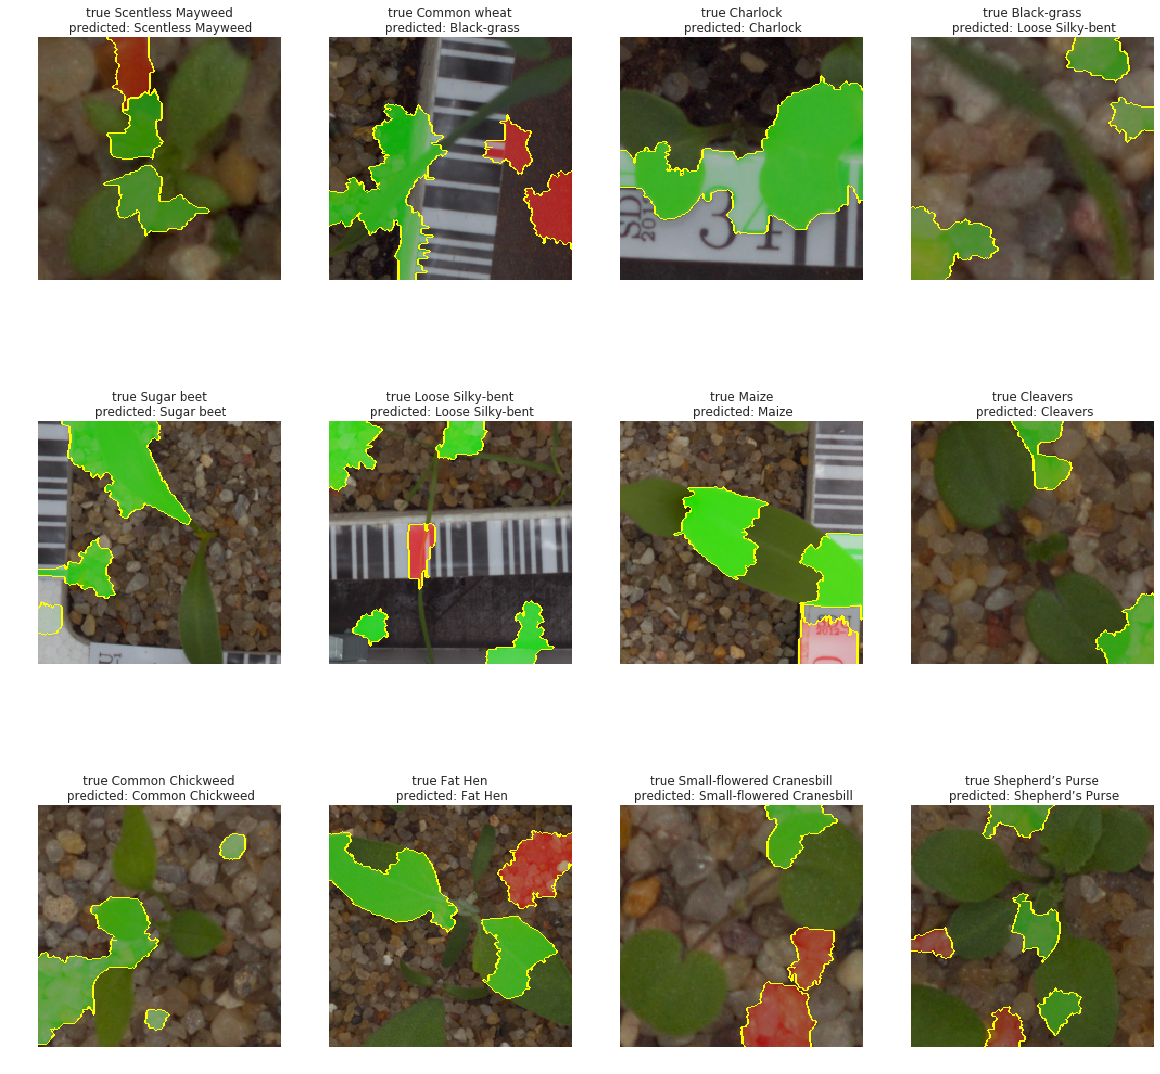

In [35]:
fig, ax = plt.subplots(3,4,figsize=(20,20))


m = 0
for i in range(3):
    for j in range(4):
        
        spec=org_plantstate.species.unique()[m]
        image_id = hold_out_data[hold_out_data.species==spec].image_name.values[0]
        image = Image.open(base_path + spec + "/" + image_id)
        image = image.convert('RGB')
        
        test_pred = batch_predict([pil_transf(image)])
        explainer = lime_image.LimeImageExplainer()

        explanation = explainer.explain_instance(np.array(pil_transf(image)), 
                                             batch_predict, # classification function
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000)
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                    positive_only=False,
                                                    num_features=5,
                                                    hide_rest=False)
        img_boundry1 = mark_boundaries(temp/255.0, mask)
        predicted_target = np.argmax(test_pred)
        predicted_species = plantstate.loc[plantstate.target==predicted_target].species.unique()[0]
        ax[i,j].imshow(img_boundry1)
        ax[i,j].axis("off")
        ax[i,j].set_title("true " + spec + "\n predicted: " + predicted_species)
        
        m+=1

Huuu!

### Insights

Do you see it?

* The **green components are those our model the used image features our model used to make its predictions**. Do you see that the green ones are **located at the stones or the measurement tape most of the time?**
* This means that our model has not extracted its knowledge from the information given by the plants!
* Now we can conclude that **we can't trust this model**. The way data was collected has led to an illness which was also not obvious without taking care about explainability in machine learning! 

## Conclusion <a class="anchor" id="summary"></a>

* Just applying a model is dangerous if you don't care about what the model has learnt. 
* A difficult part in the data science workflow is the design of the dataset and all processes of data collection. You always have to ask yourself if the dataset is what you would expect after deploying your model to the real world...

### Train as you fight in the greenhouse or on the fields!

What went wrong during data collection?

* The experimental setup of the dataset is too artifical. If you would like to use a machine learning pipeline that was developed with this dataset it's very likely to fail in a real world setting. Imagine a greenhouse setup: 
    * How do you ensure that you take images of growing plants in the same distance to the camera as in this experiment? 
    * Can you expect that the camera a company uses to feed your model with images is the same as yours in the lab?
    * We have already seen that the stones in the background led to illness during the learning process. What if we could only use the plants by using image segmentation techniques? This approach is still likely to fail as you can't expect that the background is always of the same color etc.. It could be that moss grows on the ground with similar color as your plants. How would you tackle this kind of challenge?
* What to do instead? 
    * Take images with many different setups that you would expect in the real world situation. 
    * Keep in mind to introduce variation. Use **different cameras, illumination, backgrounds, distances to plants, overlapping plants etc..** 
    * Let experts like **botanists and agriculture experts** label your target species of your images. 
    * With real world diversity in your data the model has to capture meaningful information that is given solely by the plants and nothing else! 
    * After writing this kernel I think it's important to collect the data with **Train as you fight** in your mind. :-)
    
<img src="https://cdn.pixabay.com/photo/2018/03/21/16/05/greenhouse-3247181_1280.jpg" width="600px">
